In [1]:
# VADER: https://towardsdatascience.com/sentiment-analysis-in-10-minutes-with-rule-based-vader-and-nltk-72067970fb71

In [26]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import scipy.sparse

In [27]:
def load_cleaned_submissions():
    data = pd.read_pickle("./data/cleaned_submissions.pkl")
    data = data.loc[data["sentiment"] != "", ["text", "sentiment"]] # Only get labeled instances
    return data

In [28]:
def encode_vectorize_data(data):
    # Encode labels
    lenc = LabelEncoder()
    y = lenc.fit_transform(data["sentiment"])

    # Vectorize text using tfidf
    tfidf = TfidfVectorizer(preprocessor=' '.join, lowercase=False, min_df=5) # min_df = Minimum occurance of words
    X = tfidf.fit_transform(data["text"])
    return X, y

In [29]:
def load_sparse_matrices():
    X = scipy.sparse.load_npz('./data/X_sparse.npz')
    y = np.load("./data/y_sparse.npy")
    return X, y

In [30]:
def split_train_test(X, y):
    # Train-Test Split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)
    return X_train, X_test, y_train, y_test

# SVM

In [14]:
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

pipeline = Pipeline([
        ("svc", SVC())
    ])

param_grid = {"svc__kernel": ["poly"], "svc__C": [3]} #["poly", "rbf", "sigmoid", "linear"], [3, 4, 5, 6, 7]
CV = GridSearchCV(pipeline, param_grid, cv = 5)
# pipeline.get_params().keys() See all available parameters
CV.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=Pipeline(steps=[('svc', SVC())]),
             param_grid={'svc__C': [3], 'svc__kernel': ['poly']})

In [17]:
import pickle
pickle.dump(CV, open("./data/svm_first_model_poly_3.sav", "wb"))

In [18]:
loaded_model = pickle.load(open("./data/svm_first_model_poly_3.sav", "rb"))

In [19]:
print("Accuracy of {} can be achieved with the following parameters: {}".format(loaded_model.score(X_test, y_test), CV.best_params_))

Accuracy of 0.8837895792141246 can be achieved with the following parameters: {'svc__C': 3, 'svc__kernel': 'poly'}


# Naive Bayes

In [25]:
data = load_cleaned_submissions()
X, y = load_sparse_matrices()
X_train, X_test, y_train, y_test = split_train_test(X, y)

In [32]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

pipeline = Pipeline([
        ("mnb", MultinomialNB())
    ])

param_grid = {"mnb__alpha": np.arange(0, 1, 0.1), "mnb__fit_prior": [True, False]}
CV = GridSearchCV(pipeline, param_grid, cv = 5)
# pipeline.get_params().keys() See all available parameters
CV.fit(X_train, y_train)

c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\naive_bayes.py:508: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  warnings.warn('alpha too small will result in numeric errors, '
c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\naive_bayes.py:508: UserW

GridSearchCV(cv=5, estimator=Pipeline(steps=[('mnb', MultinomialNB())]),
             param_grid={'mnb__alpha': array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
                         'mnb__fit_prior': [True, False]})

In [33]:
import pickle
pickle.dump(CV, open("./data/nb_first_model_mnb.sav", "wb"))

In [34]:
loaded_model = pickle.load(open("./data/nb_first_model_mnb.sav", "rb"))

In [35]:
print("Accuracy of {} can be achieved with the following parameters: {}".format(loaded_model.score(X_test, y_test), CV.best_params_))

Accuracy of 0.7941741624662341 can be achieved with the following parameters: {'mnb__alpha': 0.6000000000000001, 'mnb__fit_prior': False}


In [44]:
y_pred = CV.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.58      0.86      0.69      5144
           1       0.95      0.77      0.85     22421
           2       0.68      0.82      0.74      8344

    accuracy                           0.79     35909
   macro avg       0.74      0.82      0.76     35909
weighted avg       0.83      0.79      0.80     35909



# LSTM

In [31]:
from keras.models import Sequential
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical

In [32]:
# Begin DEV #
# This DEV actually works!!! Use this!!!
# https://stackoverflow.com/questions/42064690/using-pre-trained-word2vec-with-lstm-for-word-generation

In [33]:
data = load_cleaned_submissions()

In [34]:
from sklearn.preprocessing import LabelEncoder
lenc = LabelEncoder()
y_train = lenc.fit_transform(data["sentiment"].tolist())

In [35]:
sentences = data["text"].tolist()

In [36]:
max_sentence_len = 0
for sentence in sentences:
    if len(sentence) > max_sentence_len:
        max_sentence_len = len(sentence)
print(max_sentence_len)

2934


https://www.quora.com/What-are-the-strategies-to-deal-with-different-length-of-sentences-for-RNN-or-LSTM
1) If the sentences are too long, try to create an embedding that maps the words to a smaller feature space. Take a look at GloVe embeddings, Word2Vec, etc.

2) Increase the depth of the RNN. As the sequence length gets longer, it becomes harder and harder for a single layered LSTM to process the dependencies in the data. Adding more hidden layers greatly helps.

In [37]:
# Manually set it lower, because 2934 words in a sentence is quite a lot!!!
max_sentence_len = 90 # set it to 100 to have less dimensions for dev purposes

In [38]:
new_sentences = []
for sentence in sentences:
    new_sentences.append(sentence[:max_sentence_len])
sentences = new_sentences
del new_sentences

In [39]:
import gensim
word_model = gensim.models.Word2Vec(sentences, vector_size=200, min_count=1, window=5) # Vector_size = number of words??? Check params!!!

In [40]:
pretrained_weights = word_model.wv.vectors

In [41]:
vocab_size, emdedding_size =pretrained_weights.shape

In [42]:
for word in ['moon', 'short', 'robinhood', 'andromeda', 'ape', '🦍']:
  most_similar = ', '.join('%s (%.2f)' % (similar, dist) 
                           for similar, dist in word_model.wv.most_similar(word)[:8])
  print('  %s -> %s' % (word, most_similar))

  moon -> 😩 (0.98), mooning (0.97), rocket (0.97), gent (0.96), baby (0.96), brrr (0.96), plntr (0.95), cmon (0.95)
  short -> 138 (0.94), interest (0.93), unwind (0.93), 22642 (0.93), cover (0.93), gamma (0.92), float (0.92), vix (0.92)
  robinhood -> app (0.98), webull (0.98), 212 (0.98), allow (0.98), uk (0.98), rh (0.98), trade (0.98), purchase (0.97)
  andromeda -> mars (0.99), girl (0.99), goin (0.99), gang (0.99), pluto (0.99), baby (0.99), retards (0.98), 🌛 (0.98)
  ape -> fellow (0.98), autist (0.94), retard (0.94), loyal (0.94), together (0.93), strong (0.93), fledged (0.92), brother (0.92)
  🦍 -> 🙏 (0.98), 🦧 (0.98), 💪 (0.98), 🤝 (0.98), ✋ (0.97), 🍌 (0.97), 🏻 (0.97), strong (0.97)


In [43]:
def word2idx(word):
  return word_model.wv.key_to_index[word]
def idx2word(idx):
  return word_model.wv.index_to_key[idx]

In [44]:
x_train_lstm = np.zeros([len(sentences), max_sentence_len], dtype=np.int32)
y_train_lstm = np.zeros([len(sentences)], dtype=np.int32)

In [45]:
for i, sentence in enumerate(sentences):
  for t, word in enumerate(sentence):
    x_train_lstm[i, t] = word2idx(word)
  #y_train_lstm[i] = word2idx(sentence[-1])

In [46]:
print(y_train[0], data["sentiment"][0], to_categorical(y_train)[0])
print(y_train[-2], list(data["sentiment"])[-2], to_categorical(y_train)[-2])
print(y_train[6], data["sentiment"][60], to_categorical(y_train)[6])

1 bullish [0. 1. 0.]
2 neutral [0. 0. 1.]
0 bearish [1. 0. 0.]


In [47]:
y_train = to_categorical(y_train)

In [48]:
x_train_lstm, X_test_lstm, y_train, y_test = split_train_test(x_train_lstm, y_train)

In [60]:
acc = []
val_acc = []
loss = []
val_loss = []

def build_model():
    model = Sequential()
    model.add(Embedding(input_dim = vocab_size, output_dim = emdedding_size, weights = [pretrained_weights]))
    model.add(CuDNNLSTM(units = emdedding_size))
    model.add(Dropout(0.25))
    model.add(Dense(3, activation = "softmax"))
    model.compile("adam", "categorical_crossentropy", metrics = ["acc"])
    return model

model = build_model()
history = model.fit(x_train_lstm, y_train, epochs=20, validation_split=0.2, batch_size=64, verbose=2)
acc.append(history.history['acc'])
val_acc.append(history.history['val_acc'])
loss.append(history.history['loss'])
val_loss.append(history.history['val_loss'])

Epoch 1/20
180/180 - 3s - loss: 1.0310 - acc: 0.5086 - val_loss: 1.0110 - val_acc: 0.5301 - 3s/epoch - 19ms/step
Epoch 2/20
180/180 - 3s - loss: 1.0203 - acc: 0.5190 - val_loss: 1.0097 - val_acc: 0.5301 - 3s/epoch - 14ms/step
Epoch 3/20
180/180 - 3s - loss: 1.0176 - acc: 0.5190 - val_loss: 1.0101 - val_acc: 0.5298 - 3s/epoch - 14ms/step
Epoch 4/20
180/180 - 2s - loss: 1.0115 - acc: 0.5239 - val_loss: 1.0128 - val_acc: 0.5301 - 2s/epoch - 14ms/step
Epoch 5/20
180/180 - 2s - loss: 0.9937 - acc: 0.5349 - val_loss: 1.0332 - val_acc: 0.5259 - 2s/epoch - 14ms/step
Epoch 6/20
180/180 - 2s - loss: 0.9296 - acc: 0.5528 - val_loss: 0.9398 - val_acc: 0.5465 - 2s/epoch - 14ms/step
Epoch 7/20
180/180 - 2s - loss: 0.7553 - acc: 0.6565 - val_loss: 0.9307 - val_acc: 0.5698 - 2s/epoch - 14ms/step
Epoch 8/20
180/180 - 2s - loss: 0.6059 - acc: 0.7346 - val_loss: 0.9794 - val_acc: 0.5948 - 2s/epoch - 14ms/step
Epoch 9/20
180/180 - 2s - loss: 0.4695 - acc: 0.8148 - val_loss: 1.2022 - val_acc: 0.5917 - 2s/e

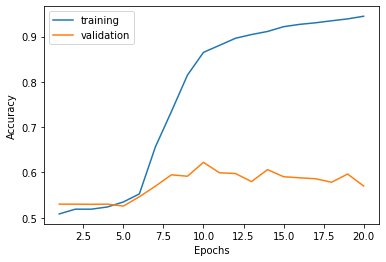

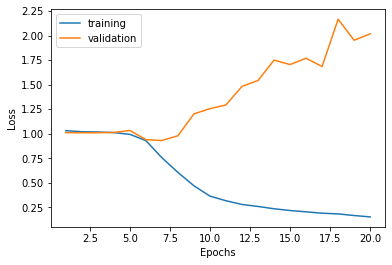

In [61]:
import matplotlib.pyplot as plt

acc_history = history.history["acc"]
val_acc_history = history.history["val_acc"]

plt.plot(range(1, len(acc_history) + 1), acc_history)
plt.plot(range(1, len(val_acc_history) + 1), val_acc_history)
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["training", "validation"])
plt.show()

loss_history = history.history["loss"]
val_loss_history = history.history["val_loss"]

plt.plot(range(1, len(loss_history) + 1), loss_history)
plt.plot(range(1, len(val_loss_history) + 1), val_loss_history)
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["training", "validation"])
plt.show()

In [62]:
test_pred = model.predict(X_test_lstm)

In [78]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [104]:
np.argmax(test_pred[3])

2

In [100]:
test_pred[3]

array([0.08388852, 0.25641242, 0.6596991 ], dtype=float32)

In [106]:
type(y_test)

numpy.ndarray

In [116]:
np.argmax(test_pred[1])

0

In [123]:
converted_test_pred = []
for i in range(len(test_pred)):
    maxi = np.argmax(test_pred[i])
    arr = np.zeros((3))
    arr[maxi] = 1
    converted_test_pred.append(arr)

In [127]:
from sklearn.metrics import classification_report
print(classification_report(y_test, converted_test_pred))

              precision    recall  f1-score   support

           0       0.50      0.43      0.46       723
           1       0.69      0.62      0.65      1871
           2       0.41      0.53      0.47       997

   micro avg       0.56      0.56      0.56      3591
   macro avg       0.53      0.53      0.53      3591
weighted avg       0.57      0.56      0.56      3591
 samples avg       0.56      0.56      0.56      3591



In [49]:
# Without loop

from keras.models import Sequential
from keras.layers import Embedding, Dense, CuDNNLSTM, Dropout

model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = emdedding_size, weights = [pretrained_weights]))
model.add(CuDNNLSTM(units = emdedding_size))
model.add(Dropout(0.25))
model.add(Dense(3, activation = "softmax"))
model.compile("adam", "categorical_crossentropy", metrics = ["acc"])
model.fit(x_train_lstm, y_train, epochs=7, validation_split=0.2, batch_size=64, verbose=2)

Epoch 1/7
180/180 - 31s - loss: 1.0326 - acc: 0.5154 - val_loss: 1.0134 - val_acc: 0.5301 - 31s/epoch - 175ms/step
Epoch 2/7
180/180 - 26s - loss: 1.0201 - acc: 0.5190 - val_loss: 1.0134 - val_acc: 0.5301 - 26s/epoch - 144ms/step
Epoch 3/7
180/180 - 3s - loss: 1.0165 - acc: 0.5191 - val_loss: 1.0104 - val_acc: 0.5301 - 3s/epoch - 15ms/step
Epoch 4/7
180/180 - 3s - loss: 1.0106 - acc: 0.5236 - val_loss: 1.0171 - val_acc: 0.5245 - 3s/epoch - 14ms/step
Epoch 5/7
180/180 - 3s - loss: 0.9919 - acc: 0.5350 - val_loss: 1.0357 - val_acc: 0.5280 - 3s/epoch - 14ms/step
Epoch 6/7
180/180 - 13s - loss: 0.9177 - acc: 0.5494 - val_loss: 0.9539 - val_acc: 0.5468 - 13s/epoch - 70ms/step
Epoch 7/7
180/180 - 15s - loss: 0.7184 - acc: 0.6630 - val_loss: 1.0004 - val_acc: 0.5600 - 15s/epoch - 82ms/step


In [50]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         4268200   
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 200)               321600    
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_1 (Dense)             (None, 3)                 603       
                                                                 
Total params: 4,590,403
Trainable params: 4,590,403
Non-trainable params: 0
_________________________________________________________________


In [8]:
# End DEV #

In [7]:
X, y = load_sparse_matrices()
X_train, X_test, y_train, y_test = split_train_test(X, y)
del X, y

In [9]:
import tensorflow as tf
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


/device:GPU:0
Num GPUs Available:  1
Num GPUs Available:  1


In [8]:
# Flatten array
# Limit Size for DEV
X_train_lstm = X_train.toarray()[:10000, :, None]
# y_train_lstm = to_categorical(y_train) # To make it 2d
# y_train_lstm = y_train_lstm[:10000, :]
y_train_lstm = y_train[:10000]
# del X_train
# del y_train

In [165]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))
print(tf.config.list_physical_devices())

2.7.0
Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [166]:
physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

In [9]:
from sklearn.utils import compute_class_weight
classWeight = compute_class_weight('balanced', np.unique(y_train_lstm), y_train_lstm) 
classWeight = dict(enumerate(classWeight))

c:\DEV\Master Thesis\App\.thesis\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass classes=[0 1 2], y=[1 1 1 ... 1 1 1] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


In [10]:
classWeight

{0: 2.440214738897023, 1: 0.5340168749332479, 2: 1.3935340022296545}

In [43]:
# DEV
#from keras.optimizers import adam
#opt = SGD(lr=0.01)

from keras.layers import Embedding, Dense, CuDNNLSTM, Dropout
import tensorflow as tf
opti = tf.keras.optimizers.Adam(0.1)

m = Sequential()
# m.add(Embedding(X_train_lstm.shape[1], 512)) # Input dim is X_train_lstm.shape[1], dim is the output dimensionality
m.add(CuDNNLSTM(32))
m.add(Dropout(0.1))
m.add(Dense(1, activation = "softmax"))
m.compile(optimizer = opti, loss =  "categorical_crossentropy", metrics = ["accuracy"])
history = m.fit(X_train, y_train, epochs=5, batch_size=64, verbose=2, class_weight = classWeight)

Epoch 1/5


ValueError: in user code:

    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\engine\training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\engine\training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\engine\training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\engine\training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\DEV\Master Thesis\App\.thesis\lib\site-packages\keras\engine\input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_10" (type Sequential).
    
    Input 0 of layer "cu_dnnlstm_10" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 2050)
    
    Call arguments received:
      • inputs=<tensorflow.python.framework.sparse_tensor.SparseTensor object at 0x00000206DECB8040>
      • training=True
      • mask=None


In [13]:
from keras.models import Sequential
from keras.layers import Embedding, Dense, CuDNNLSTM, Dropout

def build_model(input_dim, output_dim, hidden_states, opt):
    model = Sequential()
    model.add(Embedding(input_dim, output_dim)) # Input dim is X_train_lstm.shape[1], dim is the output dimensionality
    model.add(CuDNNLSTM(hidden_states))
    model.add(Dropout(0.1))
    model.add(Dense(3, activation = "softmax"))
    model.compile(opt, "categorical_crossentropy", metrics = ["acc"])
    return model

In [16]:
dim = [512] #[256, 512, 1024]
hidden_states = [16] #[16, 32, 64]
optimi = ["Adam"] #["rmsprop", "SGD", "Adam"]

acc = []
val_acc = []
loss = []
val_loss = []

param_list = []

for d in dim:
    for state in hidden_states:
        for opt in optimi:
            # optimizer = tf.keras.optimizers.Adam(0.001)
            # optimizer.learning_rate.assign(0.01)
            model = build_model(X_train_lstm.shape[1], d, state, opt)
            history = model.fit(X_train_lstm, y_train_lstm, epochs=5, batch_size=64, validation_split=0.2, verbose=2)
            acc.append(history.history['acc'])
            val_acc.append(history.history['val_acc'])
            loss.append(history.history['loss'])
            val_loss.append(history.history['val_loss'])
            param_list.append("Optimizer: " + opt + " - States: " + str(state) + " - Dimensions:" + str(d))


Epoch 1/5
125/125 - 12s - loss: 0.9262 - acc: 0.6177 - val_loss: 0.8930 - val_acc: 0.6345 - 12s/epoch - 98ms/step
Epoch 2/5
125/125 - 11s - loss: 0.9168 - acc: 0.6216 - val_loss: 0.8927 - val_acc: 0.6345 - 11s/epoch - 92ms/step
Epoch 3/5
125/125 - 11s - loss: 0.9158 - acc: 0.6216 - val_loss: 0.8937 - val_acc: 0.6345 - 11s/epoch - 91ms/step
Epoch 4/5
125/125 - 12s - loss: 0.9145 - acc: 0.6216 - val_loss: 0.8932 - val_acc: 0.6345 - 12s/epoch - 92ms/step
Epoch 5/5
125/125 - 11s - loss: 0.9156 - acc: 0.6216 - val_loss: 0.8928 - val_acc: 0.6345 - 11s/epoch - 91ms/step


In [44]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 512)         1049600   
                                                                 
 cu_dnnlstm_3 (CuDNNLSTM)    (None, 32)                69888     
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1,119,521
Trainable params: 1,119,521
Non-trainable params: 0
_________________________________________________________________


In [54]:
# Save Model
from keras.models import load_model
history.model.save('./data/small_lstm_model.h5')

In [55]:
loaded_model = load_model('./data/small_lstm_model.h5')

In [57]:
print(loaded_model.history)

None


In [62]:
print(loaded_model.history)

None


In [42]:
print(history.history) # Loss and Accuracy

{'loss': [0.0, 0.0], 'acc': [0.6518188714981079, 0.6518188714981079]}
{'verbose': 0, 'epochs': 2, 'steps': 4489}


In [64]:
import pickle
with open('./data/train_history', 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

In [65]:
with open('./data/train_history', 'rb') as file_pi:
    h = pickle.load(file_pi)

In [66]:
print(h)

{'loss': [0.0, 0.0], 'acc': [0.6518188714981079, 0.6518188714981079]}


In [32]:
import matplotlib.pyplot as plt

def plot_history(data_list, label_list, title, xlabel='Epochs', ylabel=None):
    ''' Plots a list of vectors.

    Parameters:
        data_list  : list of vectors containing the values to plot
        label_list : list of labels describing the data, one per vector
        title      : title of the plot
        ylabel     : label for the y axis
    '''
    epochs = range(1, len(data_list[0]) + 1)

    for data, label in zip(data_list, label_list):
        plt.plot(epochs, data, label=label)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend()

    plt.show()


In [33]:
plot_history(data_list=val_loss,
             label_list=[[""]*len(param_list)], #param_list,
             title='Comparison of different recurrent layer types',
             ylabel='Loss')
plot_history(data_list=val_acc,
             label_list=[[""]*len(param_list)], #param_list,
             title='Comparison of different recurrent layer types',
             ylabel='Validation accuracy')

NameError: name 'val_loss' is not defined

# BERT